In [1]:
!pip install albumentations
!pip install opencv-python
!pip install keras==2.3.1

     |████████████████████████████████| 634kB 1.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=b6a5c42b31a5c8500c768689d5281e1d4af461d931ded9974015850c817cdf4b
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 378kB 1.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.layers import (BatchNormalization, Conv2D, ZeroPadding2D, MaxPooling2D, 
GlobalAveragePooling2D, Dense, Input, Add, Activation, concatenate, UpSampling2D, LeakyReLU, MaxPool2D, Conv2DTranspose)
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import Sequence, plot_model
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sns
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import random 
import cv2
import os
import warnings

warnings.filterwarnings('ignore')

seed = 42


os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_path = '/content/gdrive/My Drive/rosneft/images'
test_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_test_images/img_for_users'
mask_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_train(masks).csv'
weight_path = '/content/gdrive/My Drive/rosneft/resnet34_imagenet_1000.h5'
test_frame_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_sub_baseline_fin.csv'

In [0]:
def jaccard_coef(y_true, y_pred, smoothing = 1.):
    intersection = tf.reduce_sum(y_true * y_pred, axis = (1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis = (1, 2))
    jaccard = (intersection + smoothing) / (union - intersection + smoothing)
    return tf.reduce_mean(jaccard)
    
def jaccard(y_true, y_pred):
    return 1. - jaccard_koef(y_true, y_pred)

def jaccard_loss(y_true, y_pred):
    return 0.75 * jaccard(y_true, y_pred) + 0.25 * binary_crossentropy(y_true, y_pred)

def dice_coef(y_true, y_pred, smoothing = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return ((2. * intersection + smoothing) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smoothing))

def dice(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return 0.75 * dice(y_true, y_pred) + 0.25 * binary_crossentropy(y_true, y_pred)

In [0]:
 def top(input_layer, filters, padding = 'same', use_bias = True):
    x = BatchNormalization(name = 'bn_top_1', scale = False)(input_layer)
    x = ZeroPadding2D(padding = (3, 3))(x)
    x = Conv2D(filters, (7, 7), strides=(2, 2), name = 'conv_top', kernel_initializer = 'he_uniform', padding = padding, use_bias = use_bias)(x)
    x = BatchNormalization(name = 'bn_top_2', )(x)
    x = Activation('relu', name = 'rel_top')(x)
    x = ZeroPadding2D(padding = (1, 1))(x)
    x = MaxPooling2D((3, 3), strides = (2, 2), padding = 'valid', name = 'pool_top')(x)
    return x

def bottom(input_layer):
    classes = 1000
    x = BatchNormalization(name = 'bn_botton')(input_layer)
    x = Activation('relu', name = 'relu_bottom')(x)
    x = GlobalAveragePooling2D(name = 'pool_bottom')(x)
    x = Dense(classes, name = 'fc_bottom')(x)
    x = Activation('softmax', name = 'softmax_bottom')(x)
    return x 


def convolution_block(x, filters, size, strides = (1,1), padding = 'same', activation = True):
    x = Conv2D(filters, size, strides = strides, padding = padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def ResBlock(input_layer, filters, strides, mode, i, padding = 'same', use_bias = True):

    x = BatchNormalization(name = i + '_bn_1')(input_layer)
    x = Activation('relu', name = i + '_relu_1')(x)
    if mode == 1:
        y = input_layer
    elif mode == 2:
        y = Conv2D(filters, (1, 1), strides = strides, name = i + 'sc', kernel_initializer = 'he_uniform', padding = padding, use_bias = use_bias)(x)
    elif mode == 3:
        y = convolution_block(filters, (3, 3), strides)
    x = ZeroPadding2D(padding = (1, 1))(x)
    x = Conv2D(filters, (3, 3), strides = strides, name = i + 'conv', kernel_initializer = 'he_uniform', padding = padding, use_bias = use_bias)(x)
    x = BatchNormalization(name = i + 'bn_2')(x)
    x = Activation('relu', name = i + 'relu_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(filters, (3, 3), name = i + 'conv_2', kernel_initializer = 'he_uniform', padding = padding, use_bias = use_bias)(x)
    x = Add()([x, y])
    return x

def build_resnet34_classification(input_shape, weight = None, include_top = True):
    input_layer = Input(shape = input_shape, name = 'input')
    x = top(input_layer, filters = 64, padding = 'valid', use_bias = False)
    for stage, (i, j) in enumerate(zip([2, 3, 5, 2],[64, 128, 256, 512])):
        if stage == 0:
            strides = (1, 1)
        else:
            strides = (2, 2)
        x = ResBlock(input_layer = x, filters = j, strides = strides, mode = 2, i = str(stage + 1), padding = 'valid', use_bias = False)
        for ind in range(i):
            x = ResBlock(input_layer = x, filters = j, strides = (1, 1), mode = 1, i = str(ind) + '_' + str(stage + 1), padding = 'valid', use_bias = False)
    x = bottom(x)
    model = Model(input_layer, x)
    if weight == 'imagenet':
        model.load_weights(weight_path)
    if include_top: 
        return model
    else:
        return Model(model.input, model.get_layer('relu_bottom').output)

In [0]:
def DecodeBlock(input_layer, filters_1, filters_2, i, padding = 'same', up_sampling = True, batchnorm = False, use_bias = False):
    x = Conv2D(filters_1, (3, 3), name = i + 'conv_1', kernel_initializer = 'he_uniform', padding = padding, use_bias = use_bias)(input_layer)
    if batchnorm:
        x = BatchNormalization(name = i + '_bn_1', axis = 3)(x)
    x = Activation('relu', name = i + '_relu_1')(x)
    x = Conv2D(filters_2, (3, 3), name = i + '_conv_2', kernel_initializer = 'he_uniform', padding = padding, use_bias = use_bias)(x)
    if batchnorm:
        x = BatchNormalization(name = i + '_bn_2', axis = 3)(x)
    x = Activation('relu', name = i + '_relu_2')(x)
    if up_sampling:
        x = UpSampling2D(size = (2, 2))(x)
    return x

def build_resnet_unet(input_shape, weight = 'imagenet', classes = 1):
    resnet34 = build_resnet34_classification(input_shape = input_shape, weight = weight, include_top = False)
    x1 = resnet34.get_layer('2_relu_1').output
    x2 = resnet34.get_layer('3_relu_1').output
    x3 = resnet34.get_layer('4_relu_1').output
    x = concatenate([UpSampling2D(size = (2,2))(resnet34.output), x3], axis = -1)
    x = DecodeBlock(x, 256, 256, i = 'decod_1')

    x = concatenate([x, x2], axis = -1)
    x = DecodeBlock(x, 128, 128, i = 'decod_2', batchnorm = True)
    x = concatenate([x, x1], axis = -1)
    x = DecodeBlock(x, 64, 64, i = 'decod_3', batchnorm = True)
    x = DecodeBlock(x, 32, 32, i = 'decod_4', batchnorm = True)
    x = DecodeBlock(x, 16, 16, i = 'decod_5', up_sampling = False, batchnorm = True)
    x = Conv2D(classes, (1, 1), name = 'prediction', kernel_initializer = 'glorot_uniform', use_bias = True, padding = 'same')(x)
    x = Activation('sigmoid', name = 'activation_predict')(x)
    model = Model(resnet34.input, x)
    return model

In [0]:
def rle2mask(mask_rle, shape):
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype = int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

In [0]:
model = build_resnet_unet((None, None, 3), weight = 'imagenet', classes = 8)

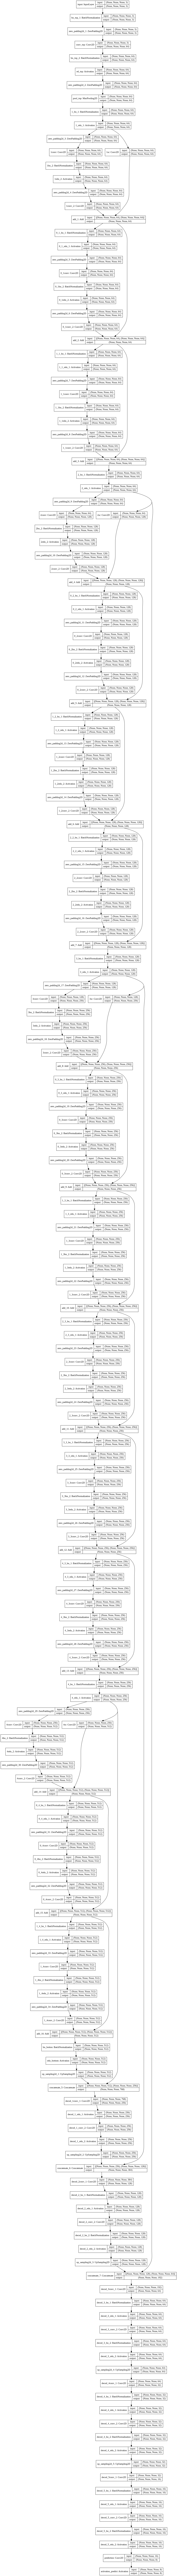

In [12]:
plot_model(model, show_shapes = True)

In [0]:
mask = pd.read_csv(mask_path)

In [14]:
mask.head(5)

,ImageId,ClassId,EncodedPixels
0,inline_3465.png,0,95 25 479 24 863 24 1246 25 1630 25 2014 25 23...
1,inline_3465.png,1,120 9 503 10 887 10 1271 10 1655 9 2039 9 2423...
2,inline_3465.png,2,129 52 513 52 897 52 1281 51 1664 52 2048 52 2...
3,inline_3465.png,3,181 33 565 32 949 32 1332 33 1716 33 2100 32 2...
4,inline_3465.png,4,214 19 597 20 981 20 1365 20 1749 19 2132 20 2...


In [15]:
inlines = []
xlines = []
for img_name in os.listdir(train_path):
    img = cv2.imread(os.path.join(train_path, img_name), cv2.IMREAD_GRAYSCALE)
    if 'inline' in img_name:
        inlines.append(img.shape)
    else:
        xlines.append(img.shape)
        
print('количество инлайнов: ', len(inlines))
print('размеры инлайнов: ', np.unique(inlines, axis = 0))
print('количество икслайнов: ', len(xlines))
print('размеры икслайнов: ', np.unique(xlines, axis = 0))
print('классы: ', mask.ClassId.unique())


del inlines, xlines, img

количество инлайнов:  512
размеры инлайнов:  [[384 384]]
количество икслайнов:  384
размеры икслайнов:  [[384 512]]
классы:  [0 1 2 3 4 5 6]


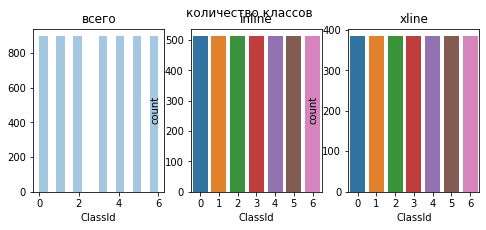

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8, 3))
sns.distplot(mask.ClassId, kde = False, ax = ax1)
sns.countplot(mask[mask.ImageId.apply(lambda s: 1 if 'inline' in s else 0).astype(bool)].ClassId, ax = ax2)
sns.countplot(mask[mask.ImageId.apply(lambda s: 1 if 'xline' in s else 0).astype(bool)].ClassId, ax = ax3)
ax1.set_title('всего')
ax2.set_title('inline')
ax3.set_title('xline')
plt.suptitle('количество классов');

In [17]:
valid_idx = np.random.choice(mask.ImageId.unique(), size = int(0.25 * len(mask.ImageId.unique())), replace = False)
valid_masks = mask[mask.ImageId.isin(valid_idx)]
train = mask[~mask.ImageId.isin(valid_idx)]
test_idx = np.random.choice(train.ImageId.unique(), size = int(0.25 * len(train.ImageId.unique())), replace = False)
test_masks = train[train.ImageId.isin(test_idx)]
train_masks = train[~train.ImageId.isin(test_idx)]
print('size of image set: {}  \n size of train set: {} \n size of valid set: {} \n size of test set: {}'.format(
    len(mask.ImageId.unique()), len(train_masks.ImageId.unique()), len(valid_masks.ImageId.unique()), len(test_masks.ImageId.unique())))

del mask, valid_idx, train, test_idx

size of image set: 896  
 size of train set: 504 
 size of valid set: 224 
 size of test set: 168


In [0]:
def read_img_mask(name_img, train_path, train, one_chanell = False):
    if one_chanell:
        img = np.expand_dims(cv2.imread(os.path.join(train_path, name_img), cv2.IMREAD_GRAYSCALE), axis = 2)
    else:
        img = cv2.imread(os.path.join(train_path, name_img))
    masks = [rle2mask(rle, shape = (img.shape[1], img.shape[0])) 
                for i, rle in enumerate(train[train['ImageId'] == name_img]['EncodedPixels'])]
    mask = np.stack(masks, axis = -1).astype('float')
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis = -1, keepdims = True)
        mask = np.concatenate((mask, background), axis = -1)
    return img, mask

class DataSet:
    def __init__(self, train_path, train, augmentation = None):
        self.train_path = train_path
        self.train = train
        self.augmentation = augmentation
        self.lines = train.ImageId.unique()
    def __getitem__(self, idx):
        name_img = self.lines[idx]
        img, mask = read_img_mask(name_img, self.train_path, self.train)
        if self.augmentation:
            aug = self.augmentation(image = img, mask = mask)
            image, mask = aug['image'], aug['mask']
        return image, mask
    def __len__(self):
        return len(self.lines)
    
class DataLoader(Sequence):    
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [0]:
def train_augmentation():
    train_transform = [
        A.Resize(384, 384),
        A.HorizontalFlip(p = 0.5),
        A.Rotate(limit = 20, p = 0.5),
        A.ElasticTransform(p = 0.5),
        A.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)),
        ]
    return A.Compose(train_transform)


def val_augmentation():
    test_transform = [
    A.Resize(384, 384),                      
    A.Normalize(
        mean = (0.485, 0.456, 0.406),
        std = (0.229, 0.224, 0.225)),
        ]
    return A.Compose(test_transform)

название изображения: xline_2400.png
размер исходного изображения: (384, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 763 ms, sys: 6.69 ms, total: 770 ms
Wall time: 762 ms


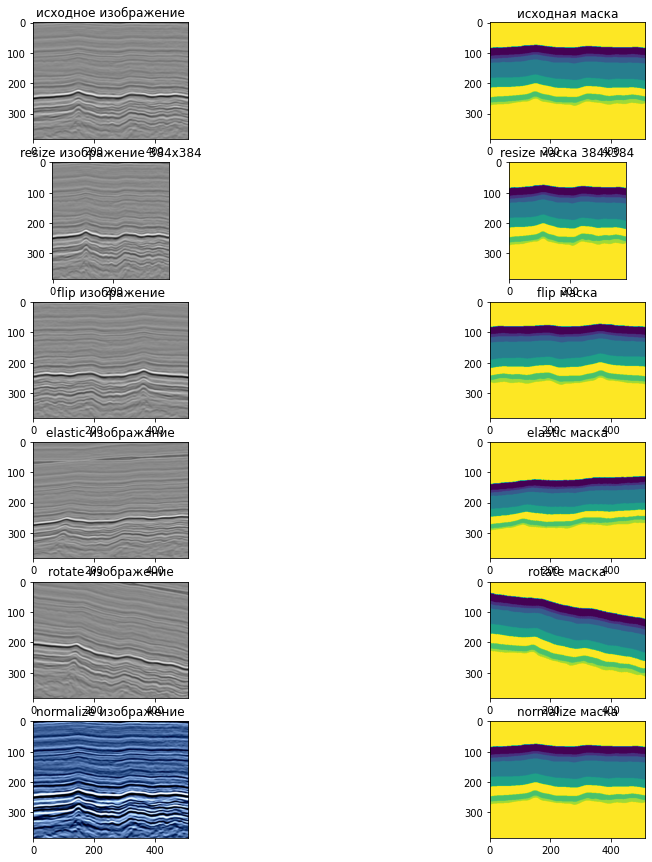

In [56]:
%%time
img_name = train_masks.ImageId.unique()[-1]
print('название изображения:', img_name)
img, mask = read_img_mask(img_name, train_path, train_masks)
print('размер исходного изображения:', img.shape)


def plot(ax, title_img, title_mask, aug):
    img, _mask = aug['image'], aug['mask']
        
    ax[0].imshow(img)
    ax[0].set_title(title_img)

    ax[1].imshow(np.argmax(_mask, axis = -1))
    ax[1].set_title(title_mask)


img_title = ['исходное изображение', 'resize изображение 384x384', 'flip изображение', 
             'elastic изображание', 'rotate изображение', 'normalize изображение']
mask_title = ['исходная маска', 'resize маска 384x384', 'flip маска', 'elastic маска',
              'rotate маска', 'normalize маска']

fig, ax = plt.subplots(len(img_title), 2, figsize = (15, 15))

origin = A.Compose([])(image = img, mask = mask)
resize = A.Compose([A.Resize(384, 384)])(image = img, mask = mask)
flip = A.Compose([A.HorizontalFlip(p = 1)])(image = img, mask = mask)
elastic = A.Compose([A.ElasticTransform(p = 1)])(image = img, mask = mask)
rotate = A.Compose([A.Rotate(limit = 20, p = 1)])(image = img, mask = mask)
normalize = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])(image = img, mask = mask)

aug = [origin, resize, flip, elastic, rotate, normalize]
for a in zip(ax, img_title, mask_title, aug): plot(*a)

In [0]:
BATCH_SIZE = 4
train_dataset = DataSet(train_path, train_masks, augmentation = train_augmentation())
valid_dataset = DataSet(train_path, valid_masks, augmentation = val_augmentation())

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [21]:
%%time

filepath = '/content/gdrive/My Drive/rosneft/weights-improvement-{epoch:02d}-{val_dice:.2f}.hdf5'        
callbacks = [
    EarlyStopping(patience  = 10, verbose = 1),
    ReduceLROnPlateau(factor = 0.1, patience = 4, min_lr = 0.00001, verbose = 1),
    ModelCheckpoint(filepath, monitor = 'val_dice', verbose = 1, save_best_only = True, mode = 'auto', period = 20),
]

total_loss = dice_loss
optim = Adam(lr = 0.0001)
metrics = [dice]
model.compile(optim, total_loss, metrics)

history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch = len(train_dataloader), 
    epochs = 200, 
    callbacks = callbacks, 
    validation_data = valid_dataloader, 
    validation_steps = len(valid_dataloader),
)

Epoch 1/200
126/126 [==============================] - 148s 1s/step - loss: 0.6884 - dice: 0.7085 - val_loss: 0.7100 - val_dice: 0.7344
Epoch 2/200
126/126 [==============================] - 124s 983ms/step - loss: 0.6303 - dice: 0.6611 - val_loss: 0.6892 - val_dice: 0.7294
Epoch 3/200
126/126 [==============================] - 131s 1s/step - loss: 0.6001 - dice: 0.6386 - val_loss: 0.6591 - val_dice: 0.7119
Epoch 4/200
126/126 [==============================] - 123s 980ms/step - loss: 0.5723 - dice: 0.6167 - val_loss: 0.6348 - val_dice: 0.6901
Epoch 5/200
126/126 [==============================] - 131s 1s/step - loss: 0.5471 - dice: 0.5957 - val_loss: 0.6197 - val_dice: 0.6764
Epoch 6/200
126/126 [==============================] - 135s 1s/step - loss: 0.5222 - dice: 0.5742 - val_loss: 0.6458 - val_dice: 0.6885
Epoch 7/200
126/126 [==============================] - 133s 1s/step - loss: 0.4961 - dice: 0.5507 - val_loss: 0.6121 - val_dice: 0.5962
Epoch 8/200
126/126 [=====================

In [50]:
history.history.keys()

dict_keys(['val_loss', 'val_dice', 'loss', 'dice', 'lr'])

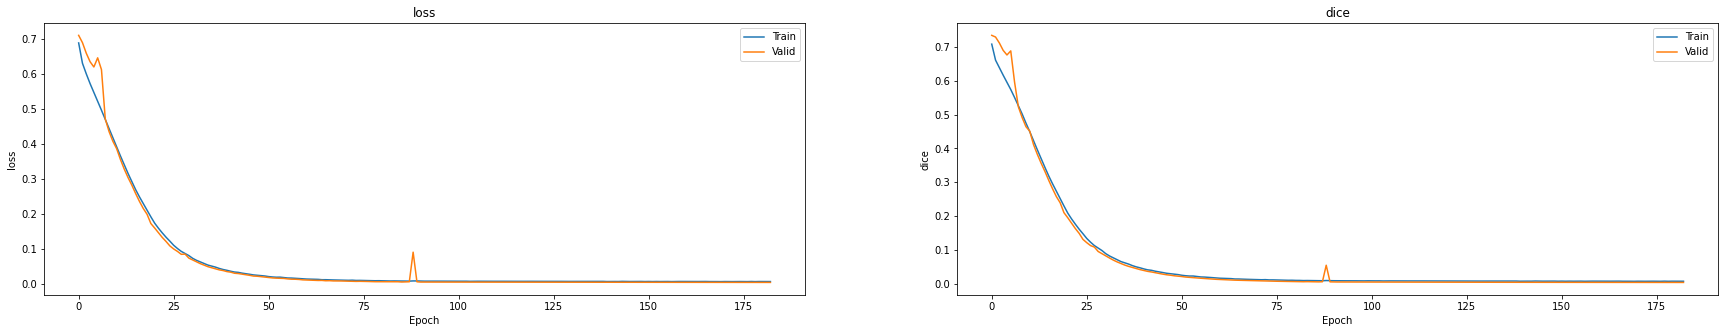

In [57]:
plt.figure(figsize = (30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc = 'upper rigth')

plt.subplot(122)
plt.plot(history.history['dice'])
plt.plot(history.history['val_dice'])
plt.title('dice')
plt.ylabel('dice')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc = 'upper rigth')
plt.show()

In [30]:
%%time
sum_error_jaccard = 0
sum_error_dice = 0
n = len(test_masks.ImageId.unique())
errors = pd.DataFrame(columns = ['image', 'jaccard', 'dice'])
for name_img in test_masks.ImageId.unique():
    img, mask = read_img_mask(name_img, train_path, test_masks)
    
    aug = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])(image = img, mask = mask)
    img, mask = aug['image'], aug['mask']
    
    img = np.expand_dims(img, axis = 0)
    pred = (model.predict(img)).astype('float32')
    mask = mask.astype('float32')
    error_jaccard = K.eval(jaccard_coef(mask, pred[0]))
    error_dice = K.eval(dice_coef(mask, pred[0]))
    errors = errors.append({
        'image': name_img,
        'jaccard': error_jaccard,
        'dice': error_dice
    }, ignore_index = True)
    sum_error_jaccard += error_jaccard
    sum_error_dice += error_dice

print('коэффициент jaccard на тестовой выборке : ', sum_error_jaccard / n)
print('коэффициент dice на тестовой выборке : ', sum_error_dice / n)

коэффициент jaccard на тестовой выборке :  0.9931607264138403
коэффициент dice на тестовой выборке :  0.9965058061338606
CPU times: user 15.1 s, sys: 3.53 s, total: 18.7 s
Wall time: 18.9 s


In [34]:
errors.sort_values(by = 'dice')

,image,jaccard,dice
0,inline_3164.png,0.990600,0.995173
88,xline_2018.png,0.990678,0.995210
167,xline_2398.png,0.990949,0.995353
87,inline_3671.png,0.991048,0.995402
159,xline_2369.png,0.991074,0.995423
...,...,...,...
136,xline_2243.png,0.994542,0.997224
76,inline_3580.png,0.994547,0.997225
45,inline_3394.png,0.994528,0.997226
62,inline_3521.png,0.994566,0.997236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


название изображения:  inline_3283.png
размер изображения:  (384, 384, 3)
размер маски:  (384, 384, 8)
размер предсказания:  (1, 384, 384, 8)
коэффициент jaccard:  0.9863722121028289


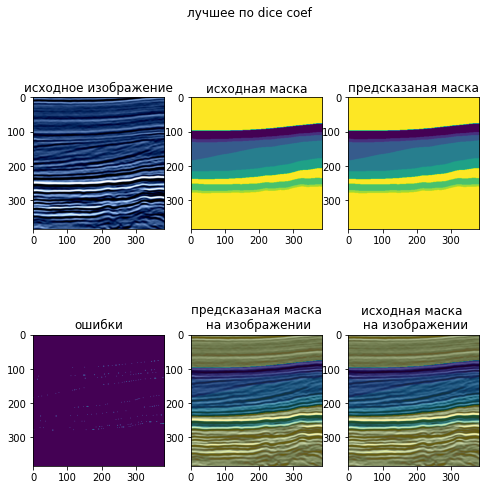

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


название изображения:  inline_3164.png
размер изображения:  (384, 384, 3)
размер маски:  (384, 384, 8)
размер предсказания:  (1, 384, 384, 8)
коэффициент jaccard:  0.97841257643726


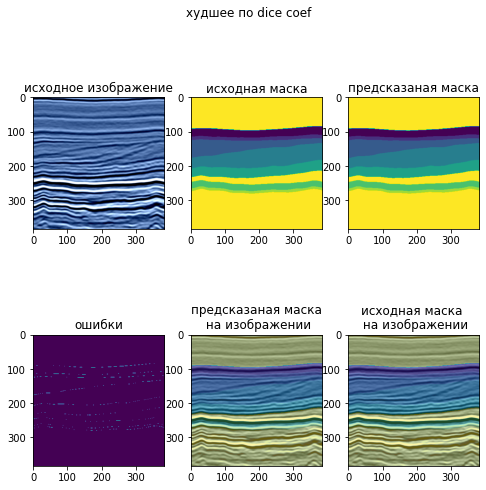

In [46]:
def draw(name_img, title):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (8, 8))
    plt.suptitle(title)
    print('название изображения: ', name_img)
    img, mask = read_img_mask(name_img, train_path, test_masks) 
    aug = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])(image = img, mask = mask)
    img, mask = aug['image'], aug['mask']

    print('размер изображения: ', img.shape)
    print('размер маски: ', mask.shape)

    ax1.imshow(img)
    ax1.set_title('исходное изображение')
    ax2.imshow(np.argmax(mask, axis = -1).astype(np.int32))
    ax2.set_title('исходная маска')

    img = np.expand_dims(img, axis = 0)
    pred = model.predict(img)
    plt.imshow(np.argmax(pred, axis = -1)[0])
    print('размер предсказания: ', pred.shape)


    ax3.imshow(np.argmax(pred, axis = -1)[0])
    ax3.set_title('предсказаная маска')

    error = (np.argmax(mask, axis = -1) != np.argmax(pred, axis = -1))
    ax4.imshow(error[0] > 0)
    ax4.set_title('ошибки')


    ax6.imshow(img[0])
    ax6.imshow(np.argmax(pred, axis = -1)[0], alpha = 0.4)
    ax6.set_title('исходная маска \n на изображении')


    ax5.imshow(img[0])
    ax5.imshow(np.argmax(mask, axis = -1), alpha = 0.4)
    ax5.set_title('предсказаная маска\n на изображении')

    print('коэффициент jaccard: ', K.eval(jaccard_coef(mask, pred)))
    plt.show()


draw('inline_3283.png', 'лучшее по dice coef')
draw('inline_3164.png', 'худшее по dice coef')